In [1]:
import pandas as pd
from itertools import chain
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences #type: ignore
from tensorflow.keras.utils import to_categorical #type: ignore
import numpy as np
import tensorflow #type: ignore
from tensorflow.keras import Sequential, Model, Input #type: ignore
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional #type: ignore
from tensorflow.keras.utils import plot_model #type: ignore
from tensorflow.keras.callbacks import EarlyStopping #type: ignore
from numpy.random import seed
import logging
import mlflow #type: ignore
import os
import time
import dagshub #type: ignore
import spacy #type: ignore
from spacy import displacy #type: ignore
import matplotlib.pyplot as plt 
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
seed(1)
tensorflow.random.set_seed(2)

In [2]:
data = pd.read_csv('../data/ner_dataset.csv', encoding='unicode_escape')

In [3]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [4]:
data.rename(columns={'Sentence #': 'Sentence'}, inplace=True)

In [5]:
def get_dict_map(data, token_or_tag):
    token2index = {}
    index2token = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))
        
    index2token = {idx: tok for idx, tok in enumerate(vocab)}
    token2index = {tok: idx for idx, tok in enumerate(vocab)}
    
    return token2index, index2token

In [6]:
token2index, index2token = get_dict_map(data, 'token')
tag2index, index2tag = get_dict_map(data, 'tag')

In [7]:
data['word_idx'] = data['Word'].map(token2index)
data['tag_idx'] = data['Tag'].map(tag2index)

In [8]:
data_fillna = data.fillna(method='ffill', axis=0)
data_group = data_fillna.groupby(['Sentence'], as_index=False)[['Word', 'POS', 'Tag', 'word_idx', 'tag_idx']].agg(lambda x: list(x))

C:\Users\DELL\AppData\Local\Temp\ipykernel_2164\1757703102.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_fillna = data.fillna(method='ffill', axis=0)


In [9]:
def get_pad_train_test_val(data_group, data):
    try: 
        n_token = len(list(set(data['Word'].to_list())))
        n_tag = len(list(set(data['Tag'].to_list())))

        tokens = data_group['word_idx'].to_list()
        maxlen = max([len(s) for s in tokens])
        pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value=n_token-1)

        tags = data_group['tag_idx'].to_list()
        pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value=tag2index['O'])
        n_tags = len(tag2index)
        pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]

        tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, random_state=2020)
        train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_, tags_, test_size=0.25, random_state=2020)

        print(
            f'''train_tokens length: {len(train_tokens)}
            \ntrain_tags length: {len(train_tags)}
            \ntest_tokens length: {len(test_tokens)}
            \ntest_tags length: {len(test_tags)}
            \nval_tokens length: {len(val_tokens)}
            \nval_tags length: {len(val_tags)}'''
        )

        return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags
    except Exception as e:
        logging.error(f'Error occured in get_pad_train_test_val function!')
        raise

In [10]:
train_tokens, test_tokens, val_tokens, train_tags, test_tags, val_tags = get_pad_train_test_val(data_group, data)

train_tokens length: 32372
            
train_tags length: 32372
            
test_tokens length: 4796
            
test_tags length: 4796
            
val_tokens length: 10791
            
val_tags length: 10791


In [11]:
input_dim = len(list(set(data['Word'].to_list()))) + 1
output_dim = 64
input_len = max([len(s) for s in data_group['word_idx'].tolist()])
n_tags = len(tag2index)

In [17]:
input_len

104

In [12]:
def get_bilstm_lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_len))
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode='concat'))
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
    model.add(TimeDistributed(Dense(n_tags, activation='relu')))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model

In [13]:
BATCH_SIZE=1000
EPOCHS=1

In [14]:
early_Stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

2025-05-20 16:34:04,674 - INFO - Starting MLflow run...
2025-05-20 16:34:05,891 - INFO - Logging processing parameters...
2025-05-20 16:34:05,937 - INFO - Initializing BiLSTM Model...
c:\Users\DELL\anaconda3\envs\mlops-ner\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

2025-05-20 16:34:06,671 - INFO - Training Neural Network...


33/33 ━━━━━━━━━━━━━━━━━━━━ 829s 21s/step - accuracy: 0.7766 - loss: 2.5177 - val_accuracy: 0.9680 - val_loss: 0.3713


2025-05-20 16:48:05,619 - INFO - Network Training Complete
2025-05-20 16:48:05,633 - INFO - Logging Training metrics...
2025-05-20 16:48:05,633 - INFO - loss: [1.0699397325515747]
2025-05-20 16:48:05,633 - INFO - accuracy: [0.9119835495948792]
2025-05-20 16:48:05,650 - INFO - val_loss: [0.3712669014930725]
2025-05-20 16:48:05,650 - INFO - val_accuracy: [0.9679761528968811]
2025-05-20 16:48:05,800 - INFO - Plotting graphs...


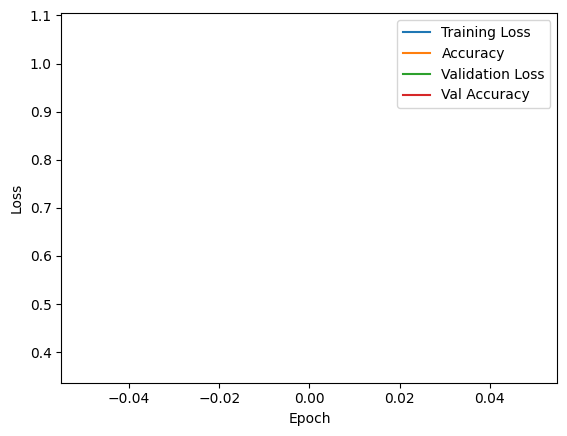

2025-05-20 16:48:07,665 - INFO - Logging Model Parameters...
2025-05-20 16:48:07,704 - INFO - Testing the model...


2025-05-20 16:48:13,799 - INFO - This is a text classification model. I will calculate metrics later, right now I am just logging model.
2025/05/20 16:48:13 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/05/20 16:49:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025-05-20 16:49:30,894 - INFO - Model training and logging completed in 925.0034062862396 seconds.
2025-05-20 16:49:30,894 - INFO - Saving model in .h5 format into models directory...
2025-05-20 16:49:30,894 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras 

In [15]:

import mlflow.tensorflow


logging.info('Starting MLflow run...')

with mlflow.start_run():
    start_time = time.time()
    try:
        logging.info('Logging processing parameters...')
        mlflow.log_param('optimizer', 'Adam')
        mlflow.log_param('batch_size', 1000)
        mlflow.log_param('epochs', 1)
        
        logging.info('Initializing BiLSTM Model...')
        model = get_bilstm_lstm_model()
        
        logging.info('Training Neural Network...')
        history = model.fit(train_tokens, np.array(train_tags), 
                            validation_data=(val_tokens, np.array(val_tags)), 
                            epochs=EPOCHS, 
                            batch_size=BATCH_SIZE,
                            callbacks=[early_Stopping])
        logging.info('Network Training Complete')
        
        logging.info('Logging Training metrics...')
        history = history.history
        
        logging.info(f"loss: {history['loss']}")
        logging.info(f"accuracy: {history['accuracy']}")
        logging.info(f"val_loss: {history['val_loss']}")
        logging.info(f"val_accuracy: {history['val_accuracy']}")
        
        mlflow.log_metric('loss', history['loss'][-1])
        mlflow.log_metric('accuracy', history['accuracy'][-1])
        mlflow.log_metric('val_loss', history['val_loss'][-1])
        mlflow.log_metric('val_accuracy', history['val_accuracy'][-1])
        
        logging.info('Plotting graphs...')
        plt.plot(history['loss'], label='Training Loss')
        plt.plot(history['accuracy'], label='Accuracy')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.plot(history['val_accuracy'], label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
        logging.info('Logging Model Parameters...')
        mlflow.log_param('model', 'Bi-LSTM')
        
        logging.info('Testing the model...')
        
        nlp = spacy.load("en_core_web_sm")
        text = nlp('Hi I am Divyanshu. I am from India. I like watching Anime and I am trying to become a ML Engineer')
        displacy.render(text, style='ent', jupyter=True)
        
        logging.info('This is a text classification model. I will calculate metrics later, right now I am just logging model.')
        mlflow.tensorflow.log_model(model, 'model')
        
        end_time = time.time()
        logging.info(f'Model training and logging completed in {end_time-start_time} seconds.')
        
        logging.info('Saving model in .h5 format into models directory...')
        model.save('model.h5')
        logging.info('Model Saved!')
        
    except Exception as e:
        logging.error(f"An error occurred: {e}", exc_info=True)

In [30]:
# import tf2onnx

In [ ]:
# def convert_to_onnx(model_dir_path: str, model_name: str, input_len, output_name: str):
#     model_file_path = os.path.join(model_dir_path, model_name)
#     output_path = os.path.join(model_dir_path, output_name)
#     input_signature = (tensorflow.TensorSpec(shape=(None, input_len), dtype=tensorflow.int32, name='input_ids') )
    
#     model_proto, _ = tf2onnx.convert.from_keras(
#     model_file_path,
#     input_signature=input_signature,
#     output_path=output_path,
#     opset=13
#     )

In [ ]:
# from from_root import from_root
# from src.constants import MODEL_FILE_NAME, ROOT_DIR
# model_dir_path = os.path.join(ROOT_DIR, 'models')

In [29]:
# convert_to_onnx(model_dir_path=model_dir_path, model_name=MODEL_FILE_NAME, input_len=input_len, output_name='model.onnx')